# Rock Classification and Description Using Conventional and Multispectral Drone Imagery
***
### Domenico M. Crisafulli, Misael M. Morales, Charles Neal and Carlos Torres-Verdin
#### The University of Texas at Austin, 2025
***

In [ ]:
import os, cv2, glob
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn import metrics as sklmetrics
from skimage import metrics as skimetrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d

import keras
import tensorflow as tf
import keras.backend as K
from keras import Model
from keras import layers, losses, metrics, optimizers, activations, callbacks

def check_tf_gpu(verbose:bool=True):
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    if verbose:
        print('-'*60)
        print('----------------------- VERSION INFO -----------------------')
        print('TF version: {} | # Device(s) available: {}'.format(version, count))
        print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
        print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[-1])
        print('-'*60+'\n')
    return None
check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.19.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.5.1 | cuDNN: 9
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [4]:
# Global variables
patch_size = 192
n_samples = 50

In [5]:
def CoreSegNet(in_channels:int=3, out_channels:int=1, neurons:list=[16,64,256]):
    K.clear_session()
    def convolution_block(inp, num_filters, kernel_size=3, dropout=0.1):
        _ = layers.SeparableConv2D(num_filters, kernel_size=kernel_size, padding="same")(inp)
        _ = layers.GroupNormalization(num_filters)(_)
        _ = activations.gelu(_)
        #_ = layers.SpatialDropout2D(dropout)(_)
        return _

    # Encoder
    input = layers.Input(shape=(None, None, in_channels))
    x = convolution_block(input, neurons[0])
    x = layers.MaxPooling2D(2)(x)
    f1 = x
    x = convolution_block(x, neurons[1])
    x = layers.MaxPooling2D(2)(x)
    f2 = x
    x = convolution_block(x, neurons[2])
    x = layers.MaxPooling2D(2)(x)
    f3 = x
    
    # Decoder
    x = layers.concatenate([x, f3])
    x = convolution_block(x, neurons[2])
    x = layers.Conv2DTranspose(neurons[1], kernel_size=2, strides=2, padding='same')(x)

    x = layers.concatenate([x, f2])
    x = convolution_block(x, neurons[1])
    x = layers.Conv2DTranspose(neurons[0], kernel_size=2, strides=2, padding='same')(x)

    x = layers.concatenate([x, f1])
    x = convolution_block(x, neurons[0])
    x = layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2, padding='same')(x)

    output = layers.Conv2D(out_channels, kernel_size=1, strides=1, activation='softmax')(x)
    
    return Model(inputs=input, outputs=output)

In [6]:
class CustomLoss(losses.Loss):
    def __init__(self, segmentation_weight=0.90, perceptual_weight=0.05, alpha=0.50, beta=0.50, gamma=0.50):
        super(CustomLoss, self).__init__()
        '''
        alpha: controls the weight of categorical cross-entropy (vs. focal)
        beta:  controls the weight of mse (vs. mae)
        gamma: controls the weight of ssim (vs. psnr)
        '''
        self.a     = segmentation_weight
        self.b     = perceptual_weight if segmentation_weight != 1 else 0
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma
        self.focal = losses.CategoricalFocalCrossentropy()

    def call(self, true, pred):
        cce = losses.categorical_crossentropy(true, pred)
        foc = self.focal(true, pred)
        segmentation = self.alpha * cce + (1-self.alpha) * foc

        mse = tf.reduce_mean(tf.square(true - pred))
        mae = tf.reduce_mean(tf.abs(true - pred))
        reconstruction = self.beta * mse + (1-self.beta) * mae

        true_ = (true - keras.ops.min(true)) / (keras.ops.max(true) - keras.ops.min(true))
        pred_ = (pred - keras.ops.min(pred)) / (keras.ops.max(pred) - keras.ops.min(pred))
        ssim = 1 - tf.reduce_mean(tf.image.ssim(true_, pred_, max_val=1.0))
        psnr = 1 / tf.reduce_mean(tf.image.psnr(true_, pred_, max_val=1.0))
        perceptual = self.gamma * ssim + (1-self.gamma) * psnr

        return (self.a * segmentation) + (self.b * perceptual) + ((1-self.a-self.b) * reconstruction)

In [7]:
class MonitorCallback(keras.callbacks.Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Accuracy: {:.3f} | Loss: {:.3e}'.format(epoch+1, logs['accuracy'], logs['loss']))

***
# CoreSegNet2 - Multispectral

In [8]:
f_ms_images = os.listdir('data_new/multispectral_camera')
n_ms_images = len(f_ms_images)
print('Number of multispectral images:', n_ms_images)

Number of multispectral images: 19


In [9]:
ms_names = []
for root, dirs, files in os.walk('data_new/multispectral_camera'):
   for f in files:
      if f.endswith('.png'):
         ms_names.append(os.path.join(root, f))

ms_images_dict = {}
for i in range(n_ms_images):
   ms_images_dict[f_ms_images[i]] = []
   ff = os.path.join('data_new/multispectral_camera', str(f_ms_images[i]))
   for f in os.listdir(ff):
      if f.endswith('.png'):
         impath = os.path.join(ff, f)
         im = np.array(Image.open(impath))
         ms_images_dict[f_ms_images[i]].append(im)
ms_images = {}
for k, v in ms_images_dict.items():
   ms_images[k] = np.stack(v, axis=0)
print('Multispectral images shape:', ms_images[f_ms_images[0]].shape)

Multispectral images shape: (4, 1000, 550)


In [10]:
ms_labels_dict = {}
for i in range(n_ms_images):
   ff = os.path.join('data_new/multispectral_camera', str(f_ms_images[i]))
   ms_labels_dict[f_ms_images[i]] = {'1':{}, '2':{}, '3':{}, '4':{}}
   for f in os.listdir(ff):
      if f.endswith('_labeled.npy'):
         pp = os.path.join(ff, f)
         ch = pp.split('/')[3].split('_')[0] #channel
         vl = pp.split('/')[3].split('_')[-2] #label
         ms_labels_dict[f_ms_images[i]][ch][vl] = np.load(pp)

ms_labels = {}
for i in range(n_ms_images):
    d = ms_labels_dict[f_ms_images[i]]
    k = list(d.keys())
    kk = list(d[k[0]].keys())
    h, w = d[k[0]][kk[0]].shape
    ms_labels[f_ms_images[i]] = np.zeros((4,h,w,6))
    for c in range(1,5):
        for v in range(5):
            if str(v) in d[str(c)].keys():
                ms_labels[f_ms_images[i]][c-1,:,:,v] = d[str(c)][str(v)]
print('Multispectral labels shape:', ms_labels[f_ms_images[0]].shape)

Multispectral labels shape: (4, 1000, 550, 6)


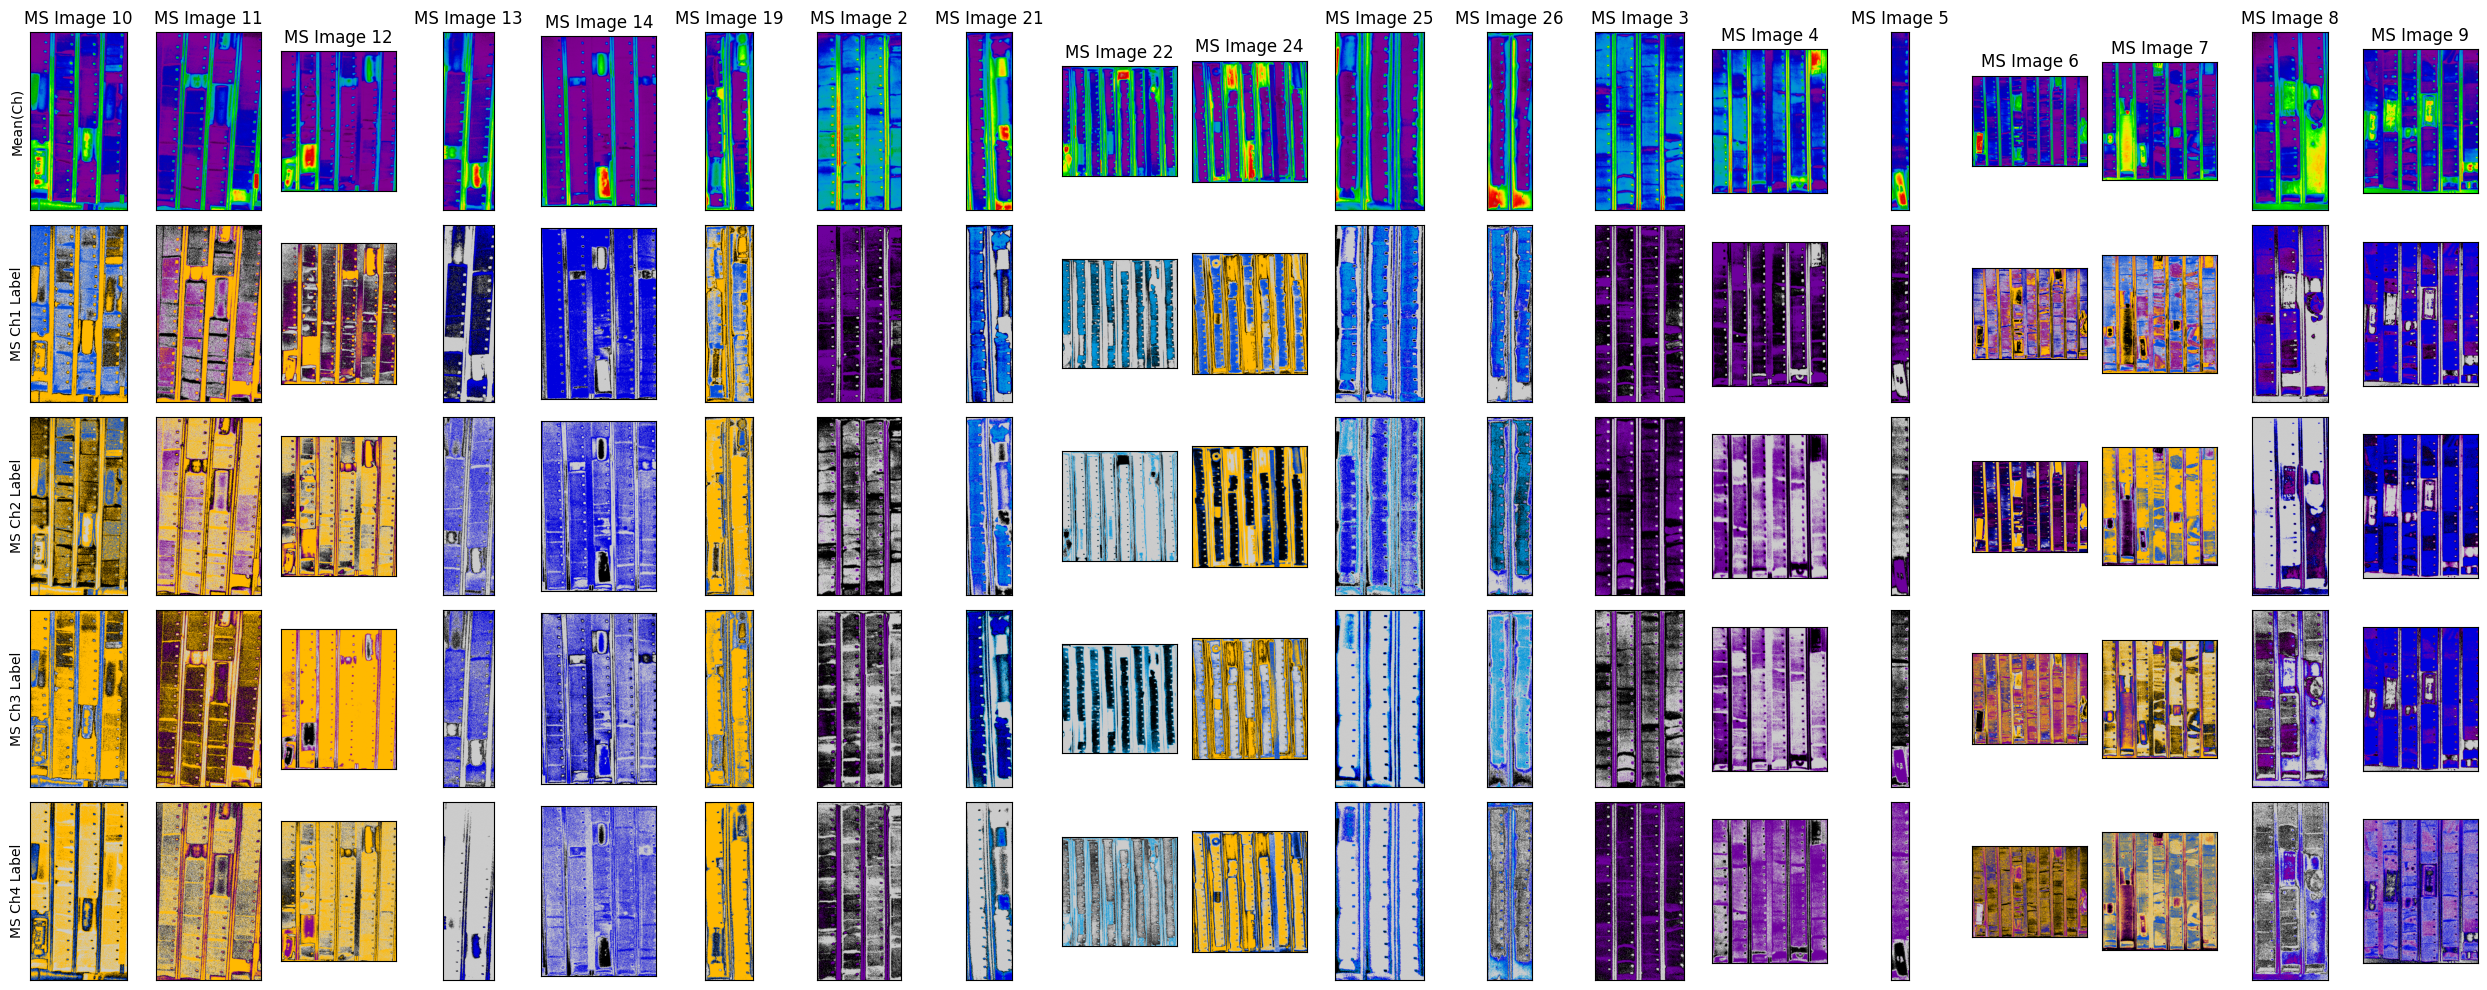

In [10]:
fig, axs = plt.subplots(5, n_ms_images, figsize=(25,10))
for j in range(n_ms_images):
    axs[0,j].set(title='MS Image {}'.format(f_ms_images[j]), ylabel='Mean(Ch)' if j==0 else None)
    axs[0,j].imshow(ms_images[f_ms_images[j]].mean(0), cmap='nipy_spectral')
    for i in range(1,5):
        axs[i,j].imshow(ms_labels[f_ms_images[j]][i-1].mean(-1), cmap='nipy_spectral')
        axs[i,j].set(ylabel='MS Ch{} Label'.format(i) if j==0 else None)
    for i in range(5):
        axs[i,j].set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [11]:
patched_images = []
for i in range(n_ms_images):
    im = ms_images[f_ms_images[i]]
    c, h, w = im.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    hh = (pad_h//2, pad_h//2) if (h + 2*(pad_h//2))%patch_size==0 else (pad_h//2+1, pad_h//2)
    ww = (pad_w//2, pad_w//2) if (w + 2*(pad_w//2))%patch_size==0 else (pad_w//2+1, pad_w//2)
    im_pad = np.pad(im, ((0,0), hh, ww), mode='constant', constant_values=0)
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = im_pad[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    patched_images.append(np.array(patches))
patched_images = np.concat(patched_images, axis=0)
print('Patched images shape:', patched_images.shape)

patched_masks = []
for i in range(n_ms_images):
    im = ms_labels[f_ms_images[i]]
    c, h, w, l = im.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    hh = (pad_h//2, pad_h//2) if (h + 2*(pad_h//2))%patch_size==0 else (pad_h//2+1, pad_h//2)
    ww = (pad_w//2, pad_w//2) if (w + 2*(pad_w//2))%patch_size==0 else (pad_w//2+1, pad_w//2)
    im_pad = np.pad(im, ((0,0), hh, ww, (0,0)), mode='constant', constant_values=0)
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = im_pad[:, i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    patched_masks.append(np.array(patches))
patched_masks = np.concat(patched_masks, axis=0)
print('Patched masks shape:', patched_masks.shape)

Patched images shape: (403, 4, 192, 192)
Patched masks shape: (403, 4, 192, 192, 6)


In [12]:
# Normalize
x_patched_ms = np.moveaxis(patched_images/255.0, 1, -1)
patched_masks_norm = np.where(patched_masks==10, 4, patched_masks)
patched_masks_norm = np.where(patched_masks_norm==13, 5, patched_masks_norm)
y_patched_ms = (patched_masks_norm / 5.0).mean(1)
print('X: {} | Y: {}'.format(x_patched_ms.shape, y_patched_ms.shape))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_patched_ms, y_patched_ms, test_size=0.1, random_state=42)
ntrain, ntest = X_train.shape[0], X_test.shape[0]
print('X_train: {} | X_test: {}'.format(X_train.shape, X_test.shape))
print('y_train: {} | y_test: {}'.format(y_train.shape, y_test.shape))

X: (403, 192, 192, 4) | Y: (403, 192, 192, 6)
X_train: (362, 192, 192, 4) | X_test: (41, 192, 192, 4)
y_train: (362, 192, 192, 6) | y_test: (41, 192, 192, 6)


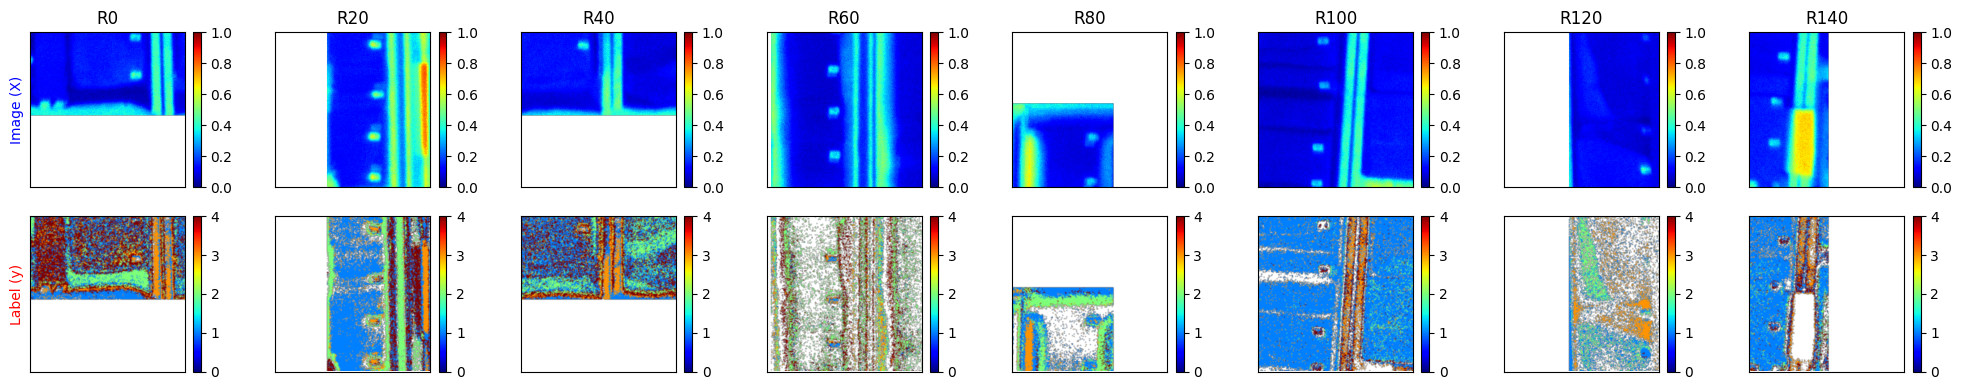

In [13]:
mult = 20
fig, axs = plt.subplots(2, 8, figsize=(20,4), sharex=True, sharey=True)
for j in range(8):
    ax1, ax2 = axs[0,j], axs[1,j]
    k = j*mult

    xx = X_train.mean(-1)[k]
    xm = np.ma.masked_where(xx == 0, xx)

    yy = y_train.argmax(-1)[k]
    ym = np.ma.masked_where(yy == 0, yy)

    im1 = ax1.imshow(xm, cmap='jet', vmin=0, vmax=1)
    im2 = ax2.imshow(ym, cmap='jet', vmin=0, vmax=4, interpolation='bicubic')

    [plt.colorbar(ii, ax=aa, fraction=0.046, pad=0.04) for ii, aa in zip([im1, im2], [ax1, ax2])]  
    [a.set(xticks=[], yticks=[]) for a in [ax1, ax2]]
    [a.set_ylabel(['Image (X)','Label (y)'][i], color=['b','r'][i]) for i, a in enumerate([ax1, ax2])] if j==0 else None
    ax1.set(title='R{}'.format(k))
plt.tight_layout()
plt.show()

In [14]:
############## Train Model ################
model = CoreSegNet(in_channels=4, out_channels=6, neurons=[16,64,128])
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

optimizer = optimizers.Adam(learning_rate=1e-3)
#criterion = CustomLoss()
#criterion = losses.CategoricalFocalCrossentropy()
criterion = losses.CategoricalFocalCrossentropy()
metricIOU = metrics.OneHotMeanIoU(num_classes=6)
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy',metricIOU])

esCallback = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = callbacks.ModelCheckpoint('model/CoreSegNet.keras', monitor='val_accuracy', save_best_only=True)
CustomCBs  = [MonitorCallback(monitor=10), esCallback, mcCallback]

# start = time()
# fit = model.fit(X_train, y_train,
#                 batch_size       = 16,
#                 epochs           = 201,
#                 validation_split = 0.2,
#                 shuffle          = True,
#                 verbose          = 0,)
#                 #callbacks        = [CustomCBs])
# print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
# model.save('models/CoreSegNet2_ms.keras')
# fit = pd.DataFrame(fit.history)
# fit.to_csv('models/CoreSegNet2_ms_history.csv', index=False)

model = keras.models.load_model('models/CoreSegNet2_ms.keras', custom_objects={'CustomLoss': CustomLoss, 'OneHotMeanIoU': metrics.OneHotMeanIoU})
fit = pd.read_csv('models/CoreSegNet2_ms_history.csv')

I0000 00:00:1765242654.886219    2363 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


# parameters: 93,876
------------------------------


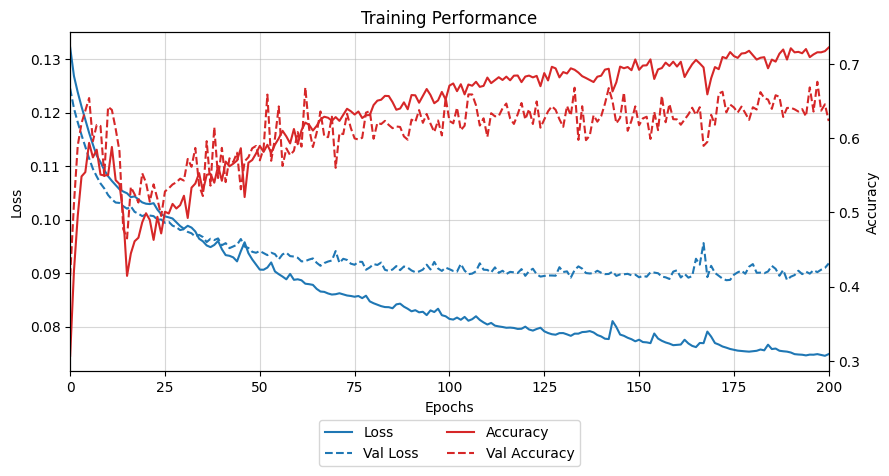

In [15]:
hues = ['tab:blue','tab:red','tab:green', 'tab:red','tab:blue','k','tab:green']

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
axb = ax.twinx()

axb.plot(fit.iloc[:,0]*1.6, color=hues[1], label='Accuracy')
axb.plot(fit.iloc[:,3]*1.8, color=hues[1], linestyle='--', label='Val Accuracy')

ax.plot(fit.iloc[:,1]/1.0, color=hues[0], label='Loss')
ax.plot(fit.iloc[:,4]/1.1, color=hues[0], linestyle='--', label='Val Loss')

# axb.plot(fit.iloc[:,2]*2.25, color=hues[2], label='IoU')
# axb.plot(fit.iloc[:,5]*2.5, color=hues[2], linestyle='--', label='Val IoU')

ax.set(xlabel='Epochs', ylabel='Loss', title='Training Performance', xlim=(0,200))
axb.set(ylabel='Accuracy')
ax.grid(True, which='both', alpha=0.5)

lines_ax, labels_ax = ax.get_legend_handles_labels()
lines_axb, labels_axb = axb.get_legend_handles_labels()
ax.legend(lines_ax + lines_axb, labels_ax + labels_axb, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))

plt.tight_layout()
plt.show()

In [16]:
y_train_pred = model.predict(X_train[:50], verbose=0)
y_test_pred  = model.predict(X_test[:50], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

I0000 00:00:1765242661.060987   12529 service.cc:152] XLA service 0x7964c010c9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765242661.061026   12529 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-12-08 19:11:01.090210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765242661.151166   12529 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-08 19:11:27.867318: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng12{k5=1,k6=0,k7=1,k10=1} for conv %cudnn-conv.20 = (f32[32,4,192,192]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,4,192,192]{3,2,1,0} %bitcast.2763, f32[4,1,3,3]{3,2,1,0} %bitcast.2770), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=4, custom_call_target="__cudnn$convForward", metadata={op_type=

Pred - train: (50, 192, 192, 6) | test: (41, 192, 192, 6)


In [17]:
encoder = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_2').output)
z_train = encoder.predict(X_train[:50], verbose=0)
z_test  = encoder.predict(X_test[:50], verbose=0)
print('Encoded - train: {} | test: {}'.format(z_train.shape, z_test.shape))

Encoded - train: (50, 24, 24, 128) | test: (41, 24, 24, 128)


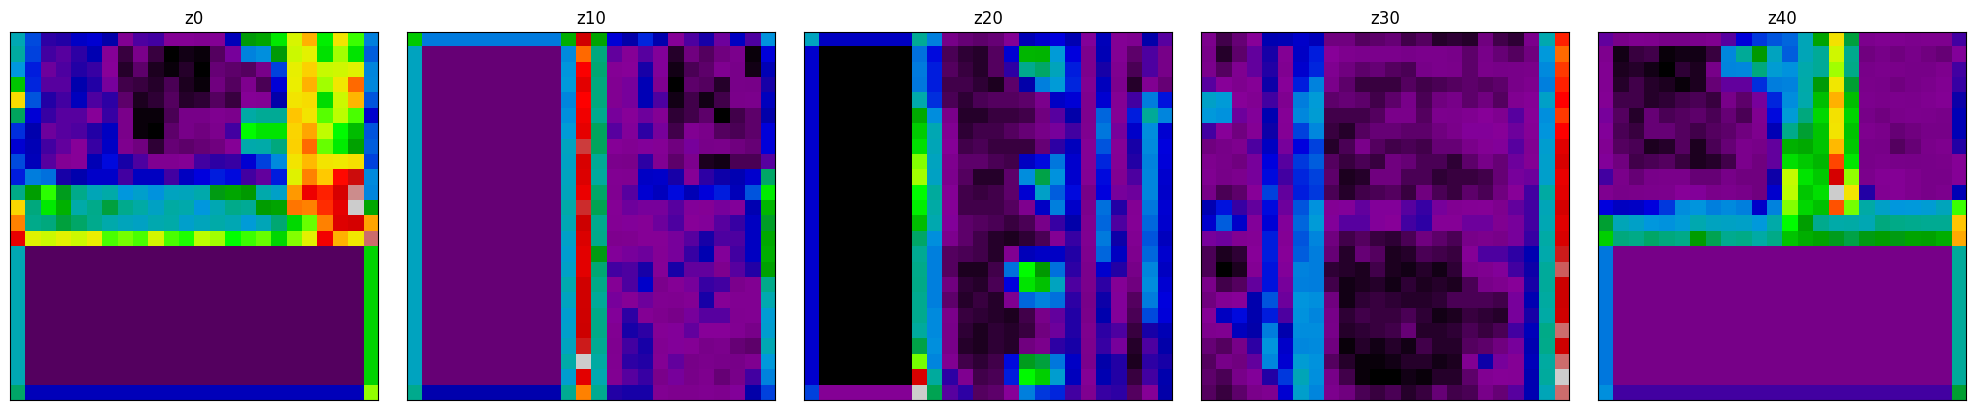

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(20,4), sharex=True, sharey=True)
mult = 10
for j in range(5):
    ax = axs[j]
    ax.imshow(z_train[j*mult].mean(-1), cmap='nipy_spectral')
    ax.set(xticks=[], yticks=[], title='z{}'.format(j*mult))
plt.tight_layout()
plt.show()

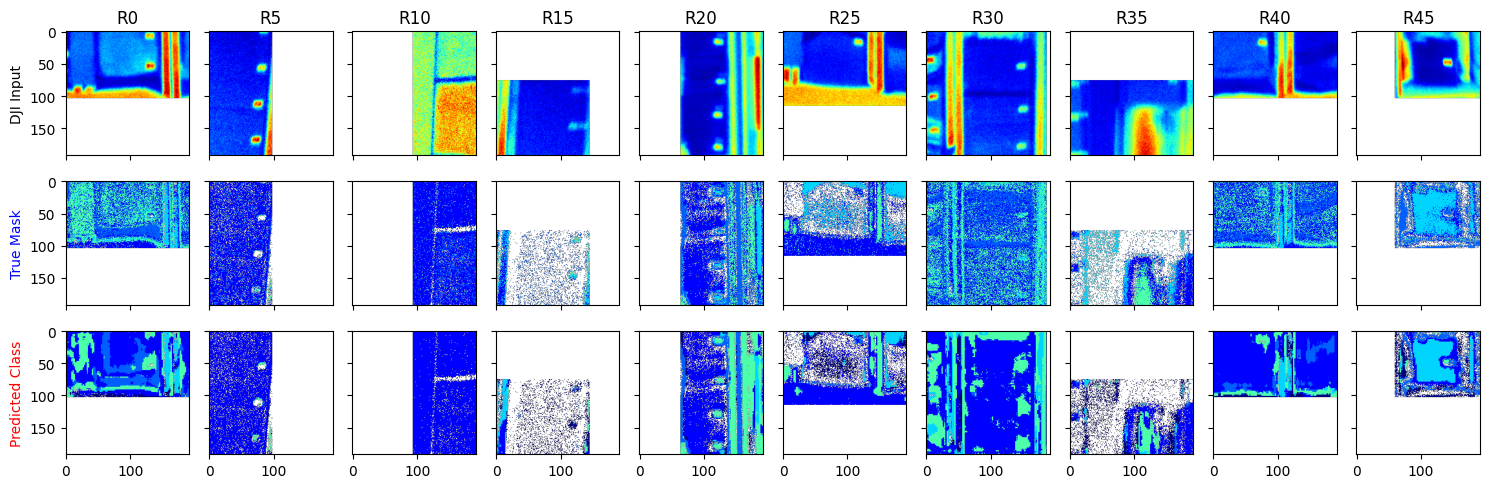

In [19]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
my_cmap = 'jet'

fig, axs = plt.subplots(3, 10, figsize=(15,5), sharex=True, sharey=True)
mult = 5
for j in range(10):
    k = j*mult
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    
    dx = np.ma.masked_where(X_train[k].mean(-1)==0, X_train[k].mean(-1))
    ax1.imshow(dx, cmap=my_cmap)
    ax1.set(title='R{}'.format(k))

    true = y_train[k].argmax(-1)
    pred = y_train_pred[k].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(true==0, pred)

    ax2.imshow(dt, vmin=0, vmax=9, cmap=my_cmap)
    ax3.imshow(dp, vmin=0, vmax=9, cmap=my_cmap)

    [a.set_ylabel(labels[i], color=colors[i]) for i,a in enumerate([ax1,ax2,ax3])] if j==0 else None

#fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [30]:
train_mse = sklmetrics.mean_squared_error(y_train[:n_samples].reshape(n_samples,-1), y_train_pred[:n_samples].reshape(n_samples,-1))
test_mse  = sklmetrics.mean_squared_error(y_test.reshape(ntest,-1), y_test_pred.reshape(ntest,-1))
print('MSE      - Train: {:.3f} | Test: {:.3f}'.format(train_mse, test_mse))

ssim_train = skimetrics.structural_similarity(y_train[:n_samples], y_train_pred[:n_samples], multichannel=True, channel_axis=-1, data_range=1.0)
ssim_test  = skimetrics.structural_similarity(y_test, y_test_pred, multichannel=True, channel_axis=-1, data_range=1.0)
print('SSIM     - Train: {:.3f} | Test: {:.3f}'.format(ssim_train, ssim_test))

acc_train = sklmetrics.accuracy_score(y_train[:n_samples].argmax(-1).flatten(), y_train_pred[:n_samples].argmax(-1).flatten())
acc_test  = sklmetrics.accuracy_score(y_test.argmax(-1).flatten(), y_test_pred.argmax(-1).flatten())
print('Accuracy - Train: {:.3f} | Test: {:.3f}'.format(acc_train, acc_test))

MSE      - Train: 0.029 | Test: 0.034
SSIM     - Train: 0.444 | Test: 0.370
Accuracy - Train: 0.437 | Test: 0.361


dd: (1, 1000, 425, 4)
yy: (1, 1000, 424, 6)


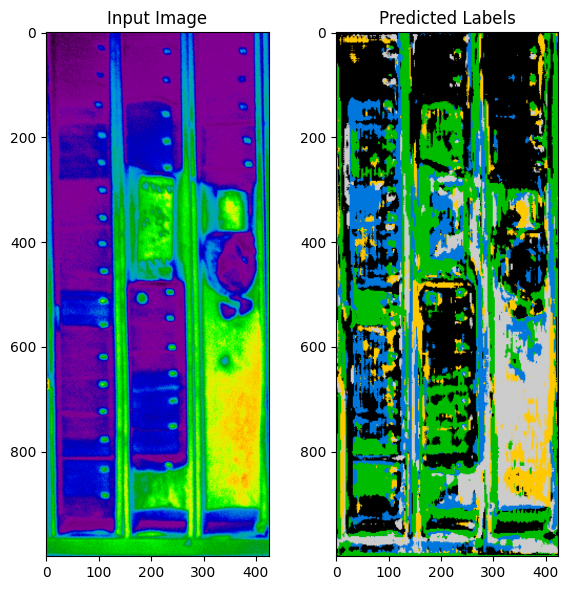

In [44]:
temp = 8
d1 = np.array(Image.open('data_new/multispectral_camera/{}/{}MS_Cropped_1.png'.format(temp,temp)))
d2 = np.array(Image.open('data_new/multispectral_camera/{}/{}MS_Cropped_2.png'.format(temp,temp)))
d3 = np.array(Image.open('data_new/multispectral_camera/{}/{}MS_Cropped_3.png'.format(temp,temp)))
d4 = np.array(Image.open('data_new/multispectral_camera/{}/{}MS_Cropped_4.png'.format(temp,temp)))
dd = np.expand_dims(np.moveaxis(np.stack([d1,d2,d3,d4], axis=0), 0, -1), 0)/255.0
print('dd: {}'.format(dd.shape))

yy = model.predict(dd, verbose=0)
print('yy: {}'.format(yy.shape))

plt.figure(figsize=(6,6))
plt.subplot(121); plt.imshow(dd.squeeze().mean(-1), cmap='nipy_spectral'); plt.title('Input Image')
plt.subplot(122); plt.imshow(yy.squeeze().argmax(-1), cmap='nipy_spectral'); plt.title('Predicted Labels')
plt.tight_layout(); plt.show()

***
# CoreSegNet2 - Conventional Camera

In [13]:
fnames = []
for root, dirs, files in os.walk('data_new/conventional_camera'):
    for f in files:
        if f.endswith('.png'):
            fnames.append(os.path.join(root, f))

cc_images = []
for i in range(len(fnames)):
    img = np.array(Image.open(fnames[i]))
    cc_images.append(img)
    print(img.shape)

(2400, 1340, 3)
(2600, 1480, 3)
(2650, 2200, 3)
(2850, 730, 3)
(2750, 1975, 3)
(2400, 550, 3)
(2350, 600, 3)
(2450, 2425, 3)
(2450, 2200, 3)
(1750, 800, 3)
(2350, 570, 3)
(2500, 1182, 3)
(2425, 1200, 3)
(2400, 1975, 3)
(2600, 250, 3)
(2500, 3160, 3)
(2520, 2400, 3)
(2500, 1050, 3)
(2450, 2050, 3)


In [14]:
def load_image(fname):
    try:
        img = Image.open(fname).convert("RGB")  # Convert grayscale to RGB
        return np.array(img)
    except Exception as e:
        print(f"Error loading {fname}: {e}")
        return None

In [15]:
def pad_image(image, patch_size=384):
    if len(image.shape) == 3:
        h, w, c = image.shape       
        pad_h = (patch_size - (h % patch_size)) % patch_size
        pad_w = (patch_size - (w % patch_size)) % patch_size
        padded_image = np.pad(image, ((pad_h//2, pad_h//2), (pad_w//2, pad_w//2), (0, 0)), mode='constant', constant_values=0)
    else:
        h, w = image.shape
        pad_h = (patch_size - (h % patch_size)) % patch_size
        pad_w = (patch_size - (w % patch_size)) % patch_size
        padded_image = np.pad(image, ((pad_h//2, pad_h//2), (pad_w//2, pad_w//2)), mode='constant', constant_values=0)
    return padded_image

In [16]:
def crop_into_patches(image, patch_size=384):
    if len(image.shape) == 3:
        h, w, c = image.shape
        patches = []
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size, :]
                if patch.shape == (patch_size, patch_size, 3):
                    patches.append(patch)
        return np.array(patches) if patches else None
    else:
        h, w = image.shape
        patches = []
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(patch)
        return np.array(patches) if patches else None

In [17]:
base_path = "data_new/conventional_camera"
cc_images_patches = []
fnames = []
for root, _, files in os.walk(base_path):
    for f in files:
        if f.lower().endswith(".png"):
            full_path = os.path.join(root, f)
            fnames.append(full_path)
if not fnames:
    print("ERROR: No PNG images were found. Check directory paths!")
else:
    print(f"Found {len(fnames)} PNG images.")

for fname in tqdm(fnames, desc='Processing images'):
    img = load_image(fname)
    if img is None:
        continue

    padded_img = pad_image(img, patch_size=patch_size)
    patches = crop_into_patches(padded_img, patch_size=patch_size)

    if patches is not None:
        cc_images_patches.append(patches)
    else:
        print(f"WARNING: No valid patches extracted from {fname}")

print("Final shape per subject:")
for i, patches in enumerate(cc_images_patches):
    print(f"Subject {i+1}: {patches.shape}")

Found 19 PNG images.


Processing images: 100%|██████████| 19/19 [00:02<00:00,  8.58it/s]

Final shape per subject:
Subject 1: (91, 192, 192, 3)
Subject 2: (112, 192, 192, 3)
Subject 3: (168, 192, 192, 3)
Subject 4: (60, 192, 192, 3)
Subject 5: (150, 192, 192, 3)
Subject 6: (39, 192, 192, 3)
Subject 7: (52, 192, 192, 3)
Subject 8: (156, 192, 192, 3)
Subject 9: (156, 192, 192, 3)
Subject 10: (50, 192, 192, 3)
Subject 11: (39, 192, 192, 3)
Subject 12: (98, 192, 192, 3)
Subject 13: (84, 192, 192, 3)
Subject 14: (130, 192, 192, 3)
Subject 15: (28, 192, 192, 3)
Subject 16: (238, 192, 192, 3)
Subject 17: (182, 192, 192, 3)
Subject 18: (84, 192, 192, 3)
Subject 19: (143, 192, 192, 3)


In [18]:
folder = "data_new/conventional_camera"
image_files = [f for f in os.listdir(folder) if f.endswith("Drone_Cropped.png")]
image_indices = [int(f.split("Drone_Cropped.png")[0]) for f in image_files]

masks, mask_data = {}, {}
for img_idx in image_indices:
    mask_files = [f for f in os.listdir(folder) if f.startswith('{}mask'.format(img_idx))]
    class_labels = [int(f.split("_")[1]) for f in mask_files]
    for c in class_labels:
        dd = np.load(os.path.join(folder, '{}mask_{}_modified.npy'.format(img_idx, c)))
        if img_idx not in masks:
            masks[img_idx] = {}
        masks[img_idx][c] = dd

for img_idx in image_indices:
    for i in range(10):
        if i not in masks[img_idx]:
            existing_classes = list(masks[img_idx].keys())
            H, W = masks[img_idx][existing_classes[0]].shape
            masks[img_idx][i] = np.zeros((H,W), dtype=np.uint8)
    mask_data[img_idx] = np.stack([masks[img_idx][i] for i in range(10)], axis=-1)

In [19]:
mask_patches = {}
for img_idx in image_indices:
    dd = mask_data[img_idx]
    dd_padded = pad_image(dd, patch_size=patch_size)
    p = []
    for i in range(10):
        p.append(crop_into_patches(dd_padded[...,i], patch_size=patch_size))
    mask_patches[img_idx] = np.stack(p, axis=-1)
        
for i, patches in enumerate(mask_patches):
    print(f"Subject {image_indices[i]}: {mask_patches[image_indices[i]].shape}")

Subject 10: (91, 192, 192, 10)
Subject 11: (112, 192, 192, 10)
Subject 12: (168, 192, 192, 10)
Subject 13: (60, 192, 192, 10)
Subject 14: (150, 192, 192, 10)
Subject 19: (39, 192, 192, 10)
Subject 21: (52, 192, 192, 10)
Subject 22: (156, 192, 192, 10)
Subject 24: (156, 192, 192, 10)
Subject 25: (50, 192, 192, 10)
Subject 26: (39, 192, 192, 10)
Subject 2: (98, 192, 192, 10)
Subject 3: (84, 192, 192, 10)
Subject 4: (130, 192, 192, 10)
Subject 5: (28, 192, 192, 10)
Subject 6: (238, 192, 192, 10)
Subject 7: (182, 192, 192, 10)
Subject 8: (84, 192, 192, 10)
Subject 9: (143, 192, 192, 10)


In [20]:
x_patched_cc = np.concatenate(cc_images_patches, axis=0)/255.0
y_patched_cc = np.concatenate(list(mask_patches.values()), axis=0)/255.0
print(f"X shape: {x_patched_cc.shape}, Y shape: {y_patched_cc.shape}")

labelmap = np.argmax(y_patched_cc, axis=-1)

X shape: (2060, 192, 192, 3), Y shape: (2060, 192, 192, 10)


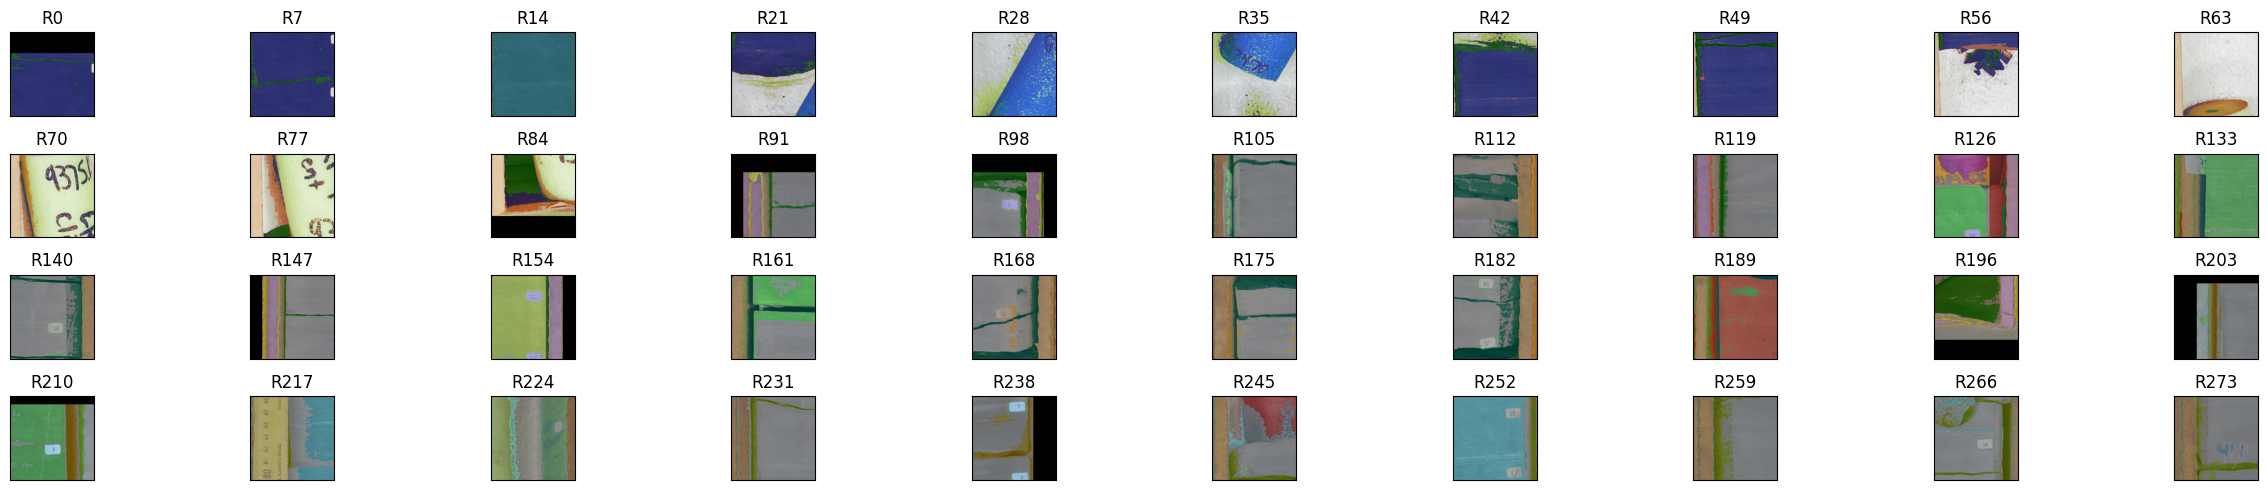

In [53]:
k, mult = 0, 7
fig, axs = plt.subplots(4, 10, figsize=(25,5))
for i in range(4):
    for j in range(10):
        ax = axs[i,j]
        ax.imshow(x_patched_cc[k*mult])
        ax.imshow(labelmap[k*mult], alpha=0.33, cmap='nipy_spectral')
        ax.set(xticks=[], yticks=[], title='R{}'.format(k*mult))
        k += 1
plt.tight_layout()
plt.show()

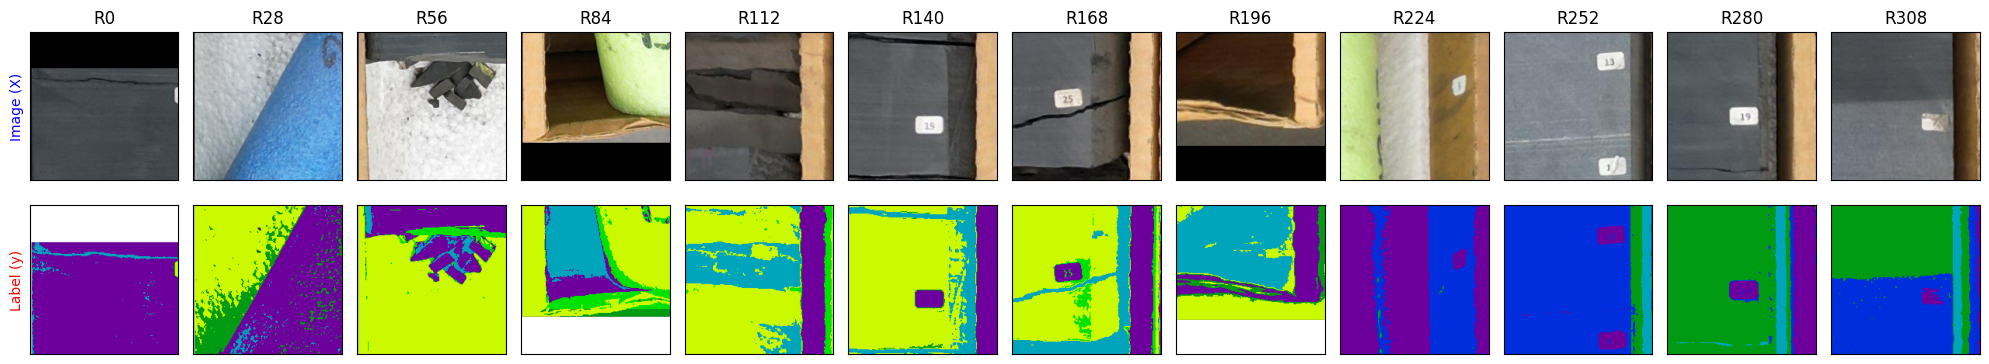

In [54]:
mult = 28
fig, axs = plt.subplots(2, 12, figsize=(20,4), sharex=True, sharey=True)
for j in range(12):
    ax1, ax2 = axs[0,j], axs[1,j]
    k = j*mult

    ax1.imshow(x_patched_cc[k])
    ax1.set(title='R{}'.format(k))

    p = y_patched_cc[k].argmax(-1)
    mp = np.ma.masked_where(p == 0, p)
    ax2.imshow(mp, cmap='nipy_spectral', vmin=0, vmax=9)

    [a.set(xticks=[], yticks=[]) for a in [ax1, ax2]]
    [a.set_ylabel(['Image (X)','Label (y)'][i], color=['b','r'][i]) for i, a in enumerate([ax1, ax2])] if j==0 else None
plt.tight_layout()
plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x_patched_cc, y_patched_cc, test_size=0.1, random_state=42)
ntrain, ntest = X_train.shape[0], X_test.shape[0]
print('X_train: {}  | X_test: {}'.format(X_train.shape, X_test.shape))
print('y_train: {} | y_test: {}'.format(y_train.shape, y_test.shape))

X_train: (1854, 192, 192, 3)  | X_test: (206, 192, 192, 3)
y_train: (1854, 192, 192, 10) | y_test: (206, 192, 192, 10)


In [85]:
############## Train Model ################
model = CoreSegNet(in_channels=3, out_channels=10, neurons=[16,64,256])
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

optimizer = optimizers.Adam(learning_rate=1e-3)
#criterion = CustomLoss()
criterion = losses.CategoricalFocalCrossentropy()
metricIOU = metrics.OneHotMeanIoU(num_classes=10)
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy',metricIOU])

esCallback = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = callbacks.ModelCheckpoint('models/CoreSegNet2_cc.keras', monitor='val_accuracy', save_best_only=True)
CustomCBs  = [MonitorCallback(monitor=10), esCallback, mcCallback]

# start = time()
# fit = model.fit(X_train, y_train,
#                 batch_size       = 16,
#                 epochs           = 101,
#                 validation_split = 0.2,
#                 shuffle          = True,
#                 verbose          = 0,)
#                 #callbacks        = [CustomCBs])
# print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
# model.save('models/CoreSegNet2_cc.keras')
# fit = pd.DataFrame(fit.history)
# fit.to_csv('models/CoreSegNet2_cc_history.csv', index=False)
model = keras.models.load_model('models/CoreSegNet2_cc.keras', custom_objects={'CustomLoss': CustomLoss, 'OneHotMeanIoU': metrics.OneHotMeanIoU})
fit = pd.read_csv('models/CoreSegNet2_cc_history.csv')

# parameters: 236,515
------------------------------


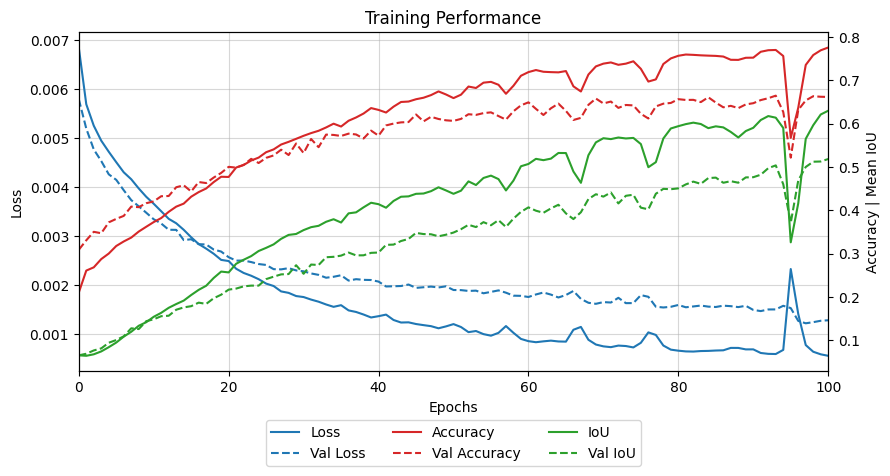

In [86]:
hues = ['tab:blue','tab:red','tab:green', 'tab:red','tab:blue','k','tab:green']

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
axb = ax.twinx()

axb.plot(fit.iloc[:,0], color=hues[1], label='Accuracy')
axb.plot(fit.iloc[:,3]*1.2, color=hues[1], linestyle='--', label='Val Accuracy')

ax.plot(fit.iloc[:,1], color=hues[0], label='Loss')
ax.plot(fit.iloc[:,4]/np.linspace(1, 2.8, 101), color=hues[0], linestyle='--', label='Val Loss')

axb.plot(fit.iloc[:,2], color=hues[2], label='IoU')
axb.plot(fit.iloc[:,5]*np.linspace(1,1.8,101), color=hues[2], linestyle='--', label='Val IoU')

ax.set(xlabel='Epochs', ylabel='Loss', title='Training Performance', xlim=(0,100))
axb.set(ylabel='Accuracy | Mean IoU')
ax.grid(True, which='both', alpha=0.5)

lines_ax, labels_ax = ax.get_legend_handles_labels()
lines_axb, labels_axb = axb.get_legend_handles_labels()
ax.legend(lines_ax + lines_axb, labels_ax + labels_axb, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3))

plt.tight_layout()
plt.show()

In [58]:
y_train_pred = model.predict(X_train[:n_samples], verbose=0)
y_test_pred  = model.predict(X_test[:n_samples], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

Pred - train: (50, 192, 192, 10) | test: (50, 192, 192, 10)


In [59]:
encoder = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_2').output)
z_train = encoder.predict(X_train[:n_samples], verbose=0)
z_test  = encoder.predict(X_test[:n_samples], verbose=0)
print('Encoded - train: {} | test: {}'.format(z_train.shape, z_test.shape))

Encoded - train: (50, 24, 24, 256) | test: (50, 24, 24, 256)


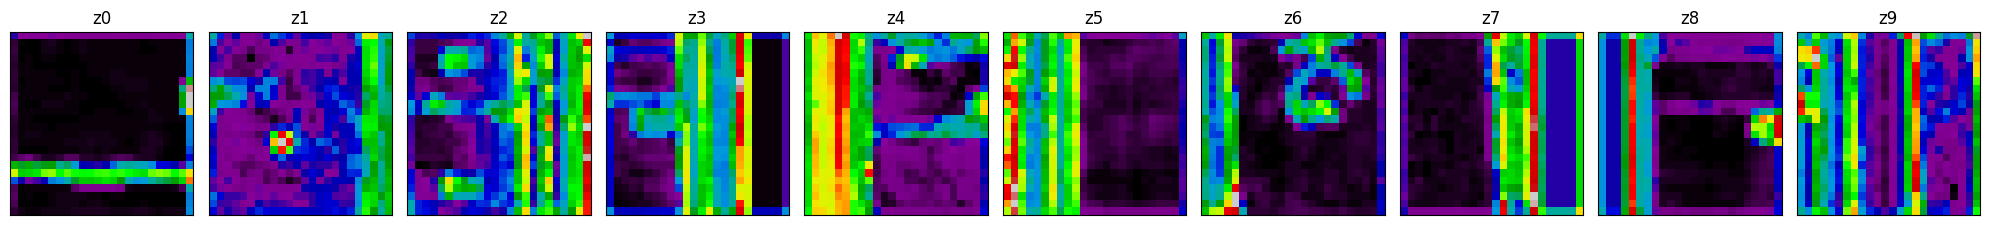

In [60]:
fig, axs = plt.subplots(1, 10, figsize=(20,4), sharex=True, sharey=True)
for j in range(10):
    ax = axs[j]
    ax.imshow(z_train[j].mean(-1), cmap='nipy_spectral')
    ax.set(xticks=[], yticks=[], title='z{}'.format(j))
plt.tight_layout()
plt.show()

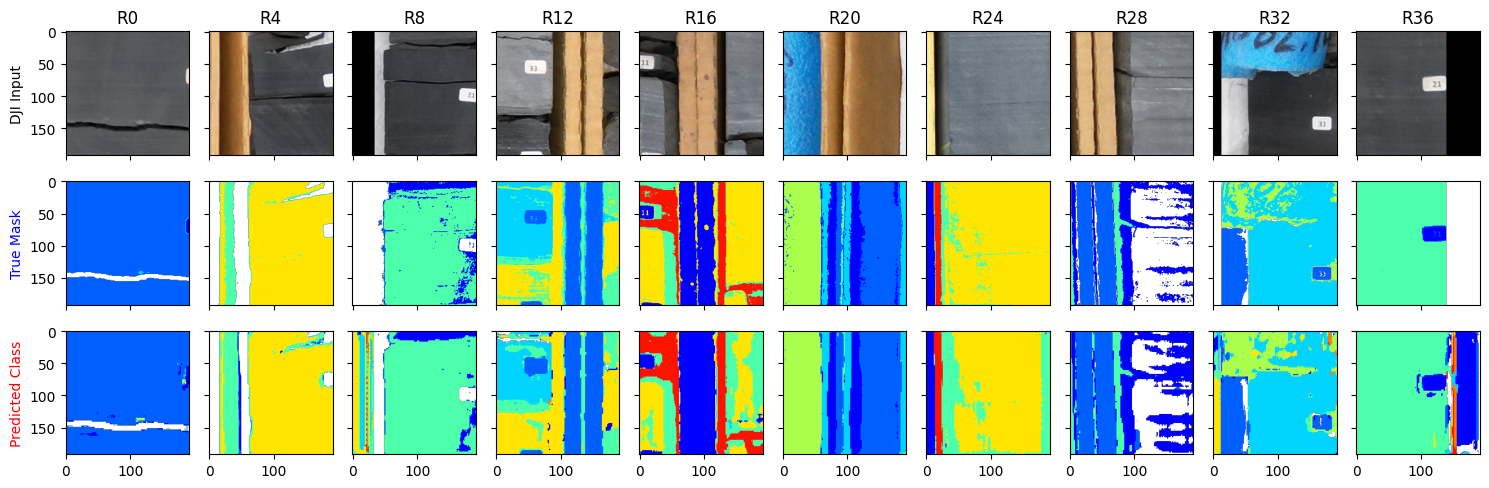

In [61]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
my_cmap = 'jet'

fig, axs = plt.subplots(3, 10, figsize=(15,5), sharex=True, sharey=True)
mult = 4

for j in range(10):
    k = j*mult
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_train[k])
    ax1.set(title='R{}'.format(k))

    true = y_train[k].argmax(-1)
    pred = y_train_pred[k].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt, vmin=0, vmax=9, cmap=my_cmap)
    ax3.imshow(dp, vmin=0, vmax=9, cmap=my_cmap)

    [a.set_ylabel(labels[i], color=colors[i]) for i,a in enumerate([ax1,ax2,ax3])] if j==0 else None

#fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [62]:
n_samples = 50
train_mse = sklmetrics.mean_squared_error(y_train[:n_samples].reshape(n_samples,-1), y_train_pred[:n_samples].reshape(n_samples,-1))
test_mse  = sklmetrics.mean_squared_error(y_test[:n_samples].reshape(n_samples,-1), y_test_pred.reshape(n_samples,-1))
print('MSE      - Train: {:.3f} | Test: {:.3f}'.format(train_mse, test_mse))

ssim_train = skimetrics.structural_similarity(y_train[:n_samples], y_train_pred[:n_samples], multichannel=True, channel_axis=-1, data_range=1.0)
ssim_test  = skimetrics.structural_similarity(y_test[:n_samples], y_test_pred[:n_samples], multichannel=True, channel_axis=-1, data_range=1.0)
print('SSIM     - Train: {:.3f} | Test: {:.3f}'.format(ssim_train, ssim_test))

acc_train = sklmetrics.accuracy_score(y_train[:n_samples].argmax(-1).flatten(), y_train_pred[:n_samples].argmax(-1).flatten())
acc_test  = sklmetrics.accuracy_score(y_test[:n_samples].argmax(-1).flatten(), y_test_pred[:n_samples].argmax(-1).flatten())
print('Accuracy - Train: {:.3f} | Test: {:.3f}'.format(acc_train, acc_test))

MSE      - Train: 0.056 | Test: 0.051
SSIM     - Train: 0.292 | Test: 0.314
Accuracy - Train: 0.816 | Test: 0.547


dd: (2450, 2050, 3)
dd: (1, 2496, 2112, 3)
yy: (2450, 2050, 10)
yy: (1, 2496, 2112, 10)


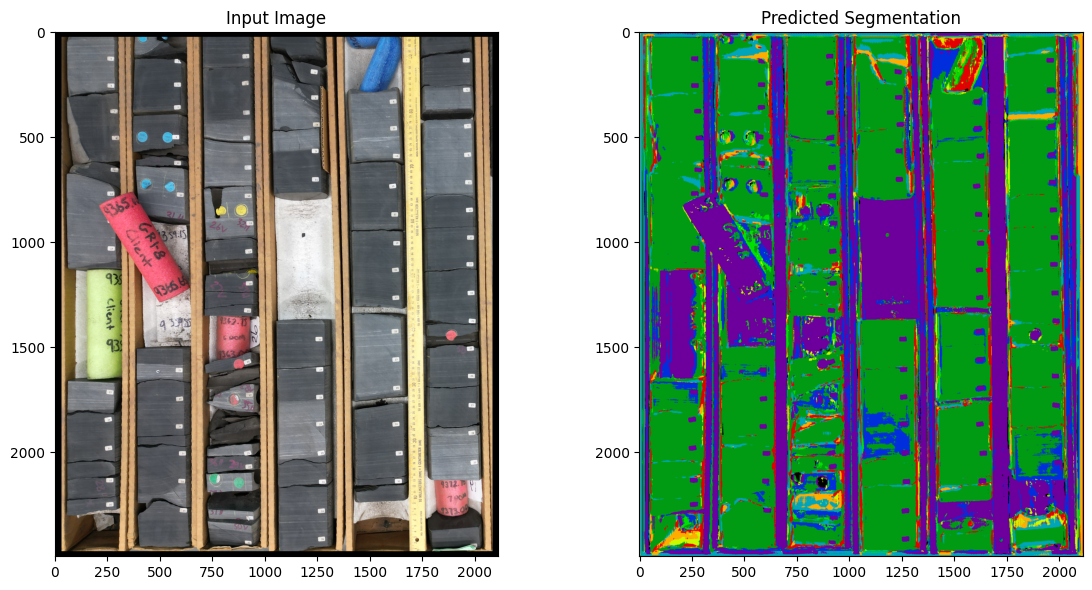

In [65]:
temp = 9
dd = np.array(Image.open('data_new/conventional_camera/{}Drone_Cropped.png'.format(temp))) / 255.0
print('dd: {}'.format(dd.shape))
dd = np.expand_dims(np.pad(dd, ((23,23), (31,31), (0,0)), mode='constant', constant_values=0), 0)
print('dd: {}'.format(dd.shape))

y0 = np.zeros((2450,2050))
y1 = np.load('data_new/conventional_camera/{}mask_1_modified.npy'.format(temp))
y2 = np.zeros((2450,2050))
y3 = np.zeros((2450,2050))
y4 = np.load('data_new/conventional_camera/{}mask_4_modified.npy'.format(temp))
y5 = np.load('data_new/conventional_camera/{}mask_5_modified.npy'.format(temp))
y6 = np.load('data_new/conventional_camera/{}mask_6_modified.npy'.format(temp))
y7 = np.load('data_new/conventional_camera/{}mask_7_modified.npy'.format(temp))
y8 = np.load('data_new/conventional_camera/{}mask_8_modified.npy'.format(temp))
y9 = np.load('data_new/conventional_camera/{}mask_9_modified.npy'.format(temp))
ytrue = np.stack([y0,y1,y2,y3,y4,y5,y6,y7,y8,y9], axis=-1)
print('yy: {}'.format(ytrue.shape))

yy = model.predict(dd, verbose=0)
print('yy: {}'.format(yy.shape))

plt.figure(figsize=(12,6))
plt.subplot(121); plt.imshow(dd.squeeze()); plt.title('Input Image')
plt.subplot(122); plt.imshow(yy.squeeze().argmax(-1), cmap='nipy_spectral'); plt.title('Predicted Segmentation')
plt.tight_layout(); plt.show()

***
# CoreSegNet2 - Combined

In [22]:
print('MS - X: {}  | Y: {}'.format(x_patched_ms.shape, y_patched_ms.shape))
print('CC - X: {} | Y: {}'.format(x_patched_cc.shape, y_patched_cc.shape))

MS - X: (403, 192, 192, 4)  | Y: (403, 192, 192, 6)
CC - X: (2060, 192, 192, 3) | Y: (2060, 192, 192, 10)


In [23]:
class MMDAlignment(layers.Layer):
    # Maximum Mean Discrepancy (MMD) Loss with Gaussian Kernel
    def __init__(self, sigma=1.0, weight=1.0, **kwargs):
        super().__init__(**kwargs)
        self.sigma = float(sigma)
        self.weight = float(weight)

    @staticmethod
    def _gaussian_mmd(x, y, sigma):
        # x,y: [B, D]
        x = tf.cast(x, tf.float32); y = tf.cast(y, tf.float32)
        x2 = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)   # [B,1]
        y2 = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)   # [M,1]
        xy = tf.matmul(x, y, transpose_b=True)                    # [B,M]

        dxx = x2 - 2*tf.matmul(x, x, transpose_b=True) + tf.transpose(x2)
        dyy = y2 - 2*tf.matmul(y, y, transpose_b=True) + tf.transpose(y2)
        dxy = x2 - 2*xy + tf.transpose(y2)

        kxx = tf.exp(-dxx / (2.0 * sigma**2))
        kyy = tf.exp(-dyy / (2.0 * sigma**2))
        kxy = tf.exp(-dxy / (2.0 * sigma**2))

        n = tf.cast(tf.shape(x)[0], tf.float32)
        m = tf.cast(tf.shape(y)[0], tf.float32)

        mmd_x  = (tf.reduce_sum(kxx) - tf.linalg.trace(kxx)) / (n*(n-1.0) + 1e-8)
        mmd_y  = (tf.reduce_sum(kyy) - tf.linalg.trace(kyy)) / (m*(m-1.0) + 1e-8)
        mmd_xy = 2.0 * tf.reduce_mean(kxy)
        return mmd_x + mmd_y - mmd_xy

    def call(self, inputs):
        pc, pm = inputs  # [B,D] each
        loss = self._gaussian_mmd(pc, pm, self.sigma)
        self.add_loss(self.weight * loss)
        # Return a dummy tensor so this fits in the graph; caller can ignore it.
        return tf.zeros((), dtype=pc.dtype)

class CORALAlignment(layers.Layer):
    # CORrelation ALignment (CORAL) Loss
    def __init__(self, weight=1.0, **kwargs):
        super().__init__(**kwargs)
        self.weight = float(weight)

    @staticmethod
    def _coral(x, y):
        x = tf.cast(x, tf.float32); y = tf.cast(y, tf.float32)
        xm = x - tf.reduce_mean(x, axis=0, keepdims=True)
        ym = y - tf.reduce_mean(y, axis=0, keepdims=True)
        n = tf.cast(tf.shape(x)[0] - 1, tf.float32)
        m = tf.cast(tf.shape(y)[0] - 1, tf.float32)
        cov_x = tf.matmul(xm, xm, transpose_a=True) / (n + 1e-8)
        cov_y = tf.matmul(ym, ym, transpose_a=True) / (m + 1e-8)
        mean_term = tf.reduce_mean(tf.square(tf.reduce_mean(x, axis=0) - tf.reduce_mean(y, axis=0)))
        cov_term  = tf.reduce_mean(tf.square(cov_x - cov_y))
        return mean_term + cov_term

    def call(self, inputs):
        pc, pm = inputs
        loss = self._coral(pc, pm)
        self.add_loss(self.weight * loss)
        return tf.zeros((), dtype=pc.dtype)


In [ ]:
# ---------- Blocks ----------
def conv_block(x, nf, k=3):
    x = layers.SeparableConv2D(nf, kernel_size=k, padding="same", use_bias=False)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = activations.gelu(x)
    return x

def build_encoder(in_channels, nf=(16,64,256), name="enc"):
    inp = layers.Input(shape=(None, None, in_channels), name=f"{name}_in")
    x = conv_block(inp, nf[0]); x = layers.MaxPooling2D(2, name=f"{name}_p1")(x); f1 = x
    x = conv_block(x, nf[1]);  x = layers.MaxPooling2D(2, name=f"{name}_p2")(x); f2 = x
    x = conv_block(x, nf[2]);  x = layers.MaxPooling2D(2, name=f"{name}_p3")(x); f3 = x
    z  = conv_block(f3, nf[2])  # bottleneck
    return Model(inp, [z, f1, f2, f3], name=name)

def build_decoder(out_classes, nf=(16,64,256), name="dec"):
    z_in  = layers.Input(shape=(None, None, nf[2]), name=f"{name}_z")
    f1_in = layers.Input(shape=(None, None, nf[0]), name=f"{name}_f1")
    f2_in = layers.Input(shape=(None, None, nf[1]), name=f"{name}_f2")
    f3_in = layers.Input(shape=(None, None, nf[2]), name=f"{name}_f3")

    x = layers.Concatenate()([z_in, f3_in])
    x = conv_block(x, nf[2])
    x = layers.Conv2DTranspose(nf[1], 2, strides=2, padding='same')(x)

    x = layers.Concatenate()([x, f2_in])
    x = conv_block(x, nf[1])
    x = layers.Conv2DTranspose(nf[0], 2, strides=2, padding='same')(x)

    x = layers.Concatenate()([x, f1_in])
    x = conv_block(x, nf[0])
    x = layers.Conv2DTranspose(out_classes, 2, strides=2, padding='same')(x)

    out = layers.Conv2D(out_classes, 1, activation="softmax", name=f"{name}_seg")(x)
    return Model([z_in, f1_in, f2_in, f3_in], out, name=name)

# ---------- Full dual-branch model ----------
def DualCoreSegNet_Unpaired(
    in_channels_cc=3,
    in_channels_ms=4,
    classes_cc=10,
    classes_ms=6,
    nf=(16,64,256),
    proj_dim=128,
    align_type="mmd",      # "mmd" or "coral"
    beta=0.05,             # weight for alignment loss
    a=0.5,                 # supervised loss mix: a*L_cc + (1-a)*L_ms
    use_focal=True,
):
    # Encoders / Decoders (no sharing)
    enc_cc = build_encoder(in_channels_cc, nf, name="enc_cc")
    enc_ms = build_encoder(in_channels_ms, nf, name="enc_ms")
    dec_cc = build_decoder(classes_cc, nf, name="dec_cc")
    dec_ms = build_decoder(classes_ms, nf, name="dec_ms")

    # Inputs
    X_cc = layers.Input(shape=(None, None, in_channels_cc), name="X_cc")
    X_ms = layers.Input(shape=(None, None, in_channels_ms), name="X_ms")

    # Forward
    zc, f1c, f2c, f3c = enc_cc(X_cc)
    zm, f1m, f2m, f3m = enc_ms(X_ms)

    Y_cc = dec_cc([zc, f1c, f2c, f3c])
    Y_ms = dec_ms([zm, f1m, f2m, f3m])

    # Project latents to a common vector space (distribution alignment works best on vectors)
    # Pool → Dense projector
    gap_c = layers.GlobalAveragePooling2D(name="gap_cc")(zc)
    gap_m = layers.GlobalAveragePooling2D(name="gap_ms")(zm)
    pc = layers.Dense(proj_dim, name="proj_cc_vec")(gap_c)
    pm = layers.Dense(proj_dim, name="proj_ms_vec")(gap_m)
    if align_type == "mmd":
        _ = MMDAlignment(sigma=1.0, weight=beta, name="align_mmd")([pc, pm])
    elif align_type == "coral":
        _ = CORALAlignment(weight=beta, name="align_coral")([pc, pm])
    else:
        raise ValueError("align_type must be 'mmd' or 'coral'")

    model = Model(inputs=[X_cc, X_ms], outputs=[Y_cc, Y_ms], name="DualCoreSegNet_Unpaired")

    # Losses & metrics
    seg_loss = losses.CategoricalFocalCrossentropy() if use_focal else losses.CategoricalCrossentropy()
    metrics_cc = ['accuracy', metrics.OneHotMeanIoU(num_classes=classes_cc)]
    metrics_ms = ['accuracy', metrics.OneHotMeanIoU(num_classes=classes_ms)]

    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss=[seg_loss, seg_loss],             # [Y_cc, Y_ms]
        loss_weights=[a, 1.0 - a],             # a*L_cc + (1-a)*L_ms
        metrics=[metrics_cc, metrics_ms] ,
    )
    return model


In [50]:
BATCH_CC = 16
BATCH_MS = 16

ds_cc = (tf.data.Dataset
         .from_tensor_slices((x_patched_cc, y_patched_cc))
         .shuffle(4096)
         .repeat()
         .batch(BATCH_CC)
         .prefetch(tf.data.AUTOTUNE))

ds_ms = (tf.data.Dataset
         .from_tensor_slices((x_patched_ms, y_patched_ms))
         .shuffle(1024)
         .repeat()
         .batch(BATCH_MS)
         .prefetch(tf.data.AUTOTUNE))

def pack(cc, ms):
    (xcc, ycc), (xms, yms) = cc, ms
    return (xcc, xms), (ycc, yms)

joint = tf.data.Dataset.zip((ds_cc, ds_ms)).map(pack, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = max(len(x_patched_cc)//BATCH_CC, len(x_patched_ms)//BATCH_MS)

2026-01-14 17:00:44.174672: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6075187200 exceeds 10% of free system memory.
2026-01-14 17:00:50.344810: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6075187200 exceeds 10% of free system memory.


In [53]:
model = DualCoreSegNet_Unpaired(
    in_channels_cc=3,
    in_channels_ms=4,
    classes_cc=10,
    classes_ms=6,
    nf=(16,64,256),
    proj_dim=128,
    align_type="mmd",
    beta=0.05,
    a=0.5,
    use_focal=True)

# history = model.fit(joint, epochs=100, steps_per_epoch=steps_per_epoch, verbose=1)
# model.save('models/CoreSegNet2_dual.keras')
# history = pd.DataFrame(history.history)
# history.to_csv('models/CoreSegNet2_dual_history.csv', index=False)

model = keras.models.load_model('models/CoreSegNet2_dual.keras', custom_objects={'MMDAlignment': MMDAlignment, 'CORALAlignment': CORALAlignment, 'CustomLoss': CustomLoss, 'OneHotMeanIoU': metrics.OneHotMeanIoU})
history = pd.read_csv('models/CoreSegNet2_dual_history.csv')
print(history.columns)

Index(['dec_cc_accuracy', 'dec_cc_loss', 'dec_cc_one_hot_mean_io_u_1',
       'dec_ms_accuracy', 'dec_ms_loss', 'dec_ms_one_hot_mean_io_u_2', 'loss'],
      dtype='object')


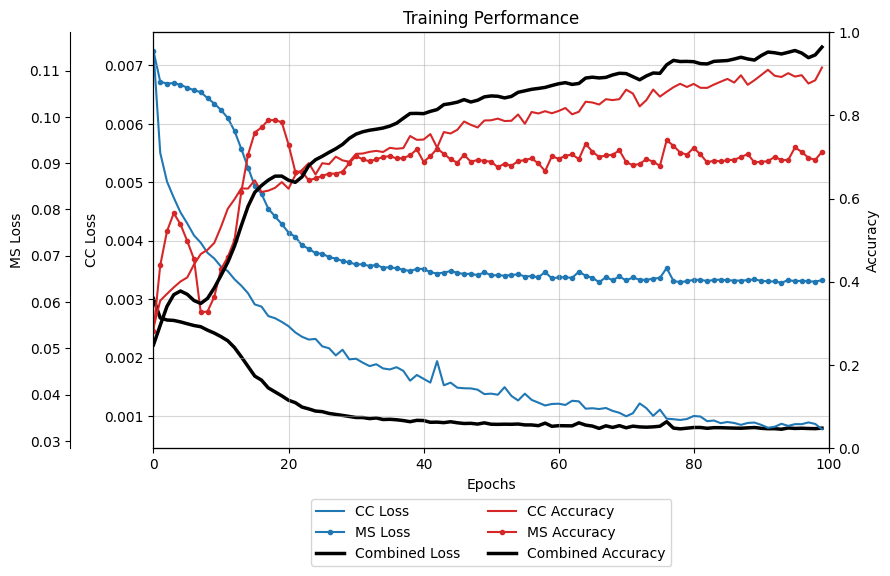

In [ ]:
hues = ['tab:blue','tab:red','tab:green', 'tab:red','tab:blue','k','tab:green']

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
axb = ax.twinx()

axa = ax.twinx()
axa.spines["left"].set_position(("outward", 60))
axa.yaxis.set_label_position("left")
axa.yaxis.set_ticks_position("left")
axa.set_zorder(ax.get_zorder() - 1) 
ax.patch.set_visible(False)

ax.plot(history['dec_cc_loss'], color=hues[0], label='CC Loss')
axa.plot(history['dec_ms_loss'], color=hues[0], label='MS Loss', marker='o', markersize=3)

axb.plot(history['dec_cc_accuracy']*1.33, color=hues[1], label='CC Accuracy')
axb.plot(history['dec_ms_accuracy']*1.33, color=hues[1], label='MS Accuracy', marker='o', markersize=3)

# axb.plot(history['dec_cc_one_hot_mean_io_u_6']*1.5, color=hues[2], label='CC IoU')
# axb.plot(history['dec_ms_one_hot_mean_io_u_7']*1.5, color=hues[2], linestyle='--', label='MS IoU')

axa.plot(history['loss'], color='k', label='Combined Loss', linestyle='-', lw=2.5)
iou = (history['dec_cc_one_hot_mean_io_u_1'] + history['dec_ms_one_hot_mean_io_u_2']) + 0.12
aa = gaussian_filter1d(iou, sigma=0.8)
axb.plot(aa, color='k', label='Combined Accuracy', linestyle='-', lw=2.5)

axa.set(ylabel='MS Loss')
ax.set(xlabel='Epochs', ylabel='CC Loss', title='Training Performance', xlim=(0,100))
axb.set(ylabel='Accuracy', ylim=(0,1))
ax.grid(True, which='both', alpha=0.5)

lines_ax, labels_ax = ax.get_legend_handles_labels()
lines_axb, labels_axb = axb.get_legend_handles_labels()
lines_axa, labels_axa = axa.get_legend_handles_labels()
ax.legend(lines_ax + lines_axa + lines_axb, labels_ax + labels_axa + labels_axb, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))

plt.tight_layout()
plt.show()

In [131]:
n_samples = 100

print('MS - X: {}  | Y: {}'.format(x_patched_ms.shape, y_patched_ms.shape))
print('CC - X: {} | Y: {}'.format(x_patched_cc.shape, y_patched_cc.shape))

y_cc_pred, y_ms_pred = model.predict([x_patched_cc[:n_samples], x_patched_ms[:n_samples]], verbose=0)
print('Pred - CC: {} | MS: {}'.format(y_cc_pred.shape, y_ms_pred.shape))

MS - X: (403, 192, 192, 4)  | Y: (403, 192, 192, 6)
CC - X: (2060, 192, 192, 3) | Y: (2060, 192, 192, 10)
Pred - CC: (100, 192, 192, 10) | MS: (100, 192, 192, 6)


In [76]:
enc_cc_trained = model.get_layer('enc_cc')
enc_ms_trained = model.get_layer('enc_ms')

enc_cc_clone = build_encoder(in_channels=3,  nf=(16,64,256), name='enc_cc_clone')
enc_ms_clone = build_encoder(in_channels=4,  nf=(16,64,256), name='enc_ms_clone')

enc_cc_clone.set_weights(enc_cc_trained.get_weights())
enc_ms_clone.set_weights(enc_ms_trained.get_weights())

z_cc_probe = Model(enc_cc_clone.input, enc_cc_clone.output[0])  # returns z-map
z_ms_probe = Model(enc_ms_clone.input, enc_ms_clone.output[0])

gap = layers.GlobalAveragePooling2D()

def get_cc_latents_standalone(X_cc, batch_size=16):
    z = z_cc_probe.predict(X_cc, batch_size=batch_size, verbose=0)   # (N, h, w, C)
    v = gap(z).numpy()  # (N, proj_dim_like) – pooled vector for viz
    return v, z

def get_ms_latents_standalone(X_ms, batch_size=16):
    z = z_ms_probe.predict(X_ms, batch_size=batch_size, verbose=0)
    v = gap(z).numpy()
    return v, z

def _tensor_hwC_from_array_and_model(X, model_input):
    H, W = int(X.shape[1]), int(X.shape[2])
    C = model_input.shape[-1]
    C = int(C) if C is not None else int(X.shape[-1])
    return H, W, C

def predict_cc(model, X_cc, batch_size=16):
    Hm, Wm, Cim = _tensor_hwC_from_array_and_model(X_cc, model.input[1])
    X_ms_dummy = np.zeros((len(X_cc), Hm, Wm, Cim), dtype=X_cc.dtype)
    y_cc_pred, _ = model.predict([X_cc, X_ms_dummy], batch_size=batch_size, verbose=0)
    return y_cc_pred

def predict_ms(model, X_ms, batch_size=16):
    Hc, Wc, Cic = _tensor_hwC_from_array_and_model(X_ms, model.input[0])
    X_cc_dummy = np.zeros((len(X_ms), Hc, Wc, Cic), dtype=X_ms.dtype)
    _, y_ms_pred = model.predict([X_cc_dummy, X_ms], batch_size=batch_size, verbose=0)
    return y_ms_pred

y_cc_pred = predict_cc(model, x_patched_cc[:n_samples])
y_ms_pred = predict_ms(model, x_patched_ms[:n_samples])
print('Pred - CC:', y_cc_pred.shape, '| MS:', y_ms_pred.shape)

cc_vec, cc_z = get_cc_latents_standalone(x_patched_cc[:n_samples])
ms_vec, ms_z = get_ms_latents_standalone(x_patched_ms[:n_samples])
print("Latent vectors CC/MS:", cc_vec.shape, ms_vec.shape)
print("Z maps CC/MS:", cc_z.shape, ms_z.shape)

Pred - CC: (100, 192, 192, 10) | MS: (100, 192, 192, 6)
Latent vectors CC/MS: (100, 256) (100, 256)
Z maps CC/MS: (100, 24, 24, 256) (100, 24, 24, 256)


Perplexity: 30 | Z2: (200, 2)


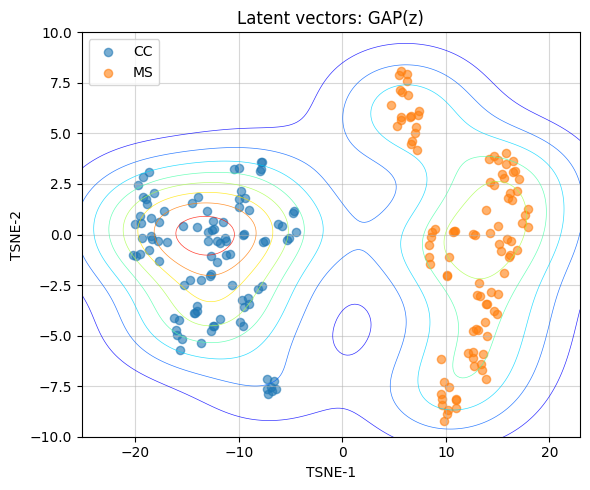

In [137]:
k = min(len(cc_vec), len(ms_vec))
Z = np.vstack([cc_vec[:k], ms_vec[:k]])
lab = np.array([0]*k + [1]*k)
perp = max(5, min(30, Z.shape[0]//3))  # must be < N

tsne = TSNE(n_components=2, init='pca', learning_rate='auto',
            perplexity=perp, random_state=42)
Z2 = tsne.fit_transform(Z)

print('Perplexity:', perp, '| Z2:', Z2.shape)

# ---- KDE for contour ----
x, y = Z2[:,0], Z2[:,1]
xy = np.vstack([x,y])
kde = gaussian_kde(xy)

# grid over data range
xi = np.linspace(x.min()-5, x.max()+5, 200)
yi = np.linspace(y.min()-5, y.max()+5, 200)
Xg, Yg = np.meshgrid(xi, yi)
Zg = kde(np.vstack([Xg.ravel(), Yg.ravel()])).reshape(Xg.shape)

# ---- Plot ----
plt.figure(figsize=(6,5))
plt.scatter(Z2[lab==0,0], Z2[lab==0,1], s=35, alpha=0.6, label='CC')
plt.scatter(Z2[lab==1,0], Z2[lab==1,1], s=35, alpha=0.6, label='MS')
cs = plt.contour(Xg, Yg, Zg, cmap='jet', linewidths=0.5, alpha=0.8, levels=10)

plt.legend(loc='upper left'); plt.grid(True, which='both', alpha=0.5)
plt.ylim(-10,10)
plt.title("Latent vectors: GAP(z)")
plt.xlabel('TSNE-1'); plt.ylabel('TSNE-2')
plt.tight_layout(); plt.show()

In [78]:
print('Pred - CC:           ', y_cc_pred.shape, '\n       MS:           ', y_ms_pred.shape)
print("Latent vectors CC/MS:", cc_vec.shape, ms_vec.shape)
print("Z maps CC/MS:        ", cc_z.shape, ms_z.shape)

Pred - CC:            (100, 192, 192, 10) 
       MS:            (100, 192, 192, 6)
Latent vectors CC/MS: (100, 256) (100, 256)
Z maps CC/MS:         (100, 24, 24, 256) (100, 24, 24, 256)


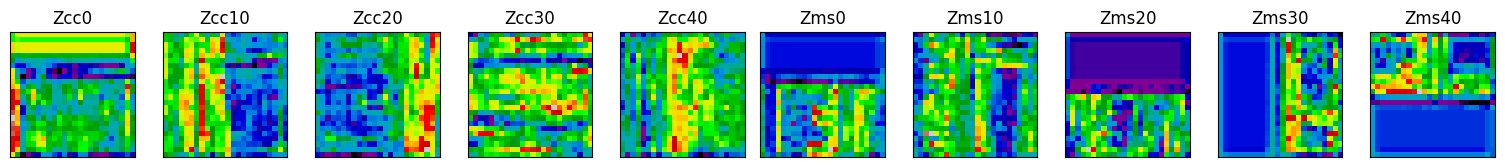

In [79]:
fig = plt.figure(figsize=(15, 4))
subfigs = fig.subfigures(1, 2)
axleft = subfigs[0].subplots(1, 5)
axright = subfigs[1].subplots(1, 5)
mult = 10
for i in range(5):
    k = i*mult
    al, ar = axleft[i], axright[i]
    al.imshow(cc_z[k].mean(-1), cmap='nipy_spectral')
    ar.imshow(ms_z[k].mean(-1), cmap='nipy_spectral')
    al.set(xticks=[], yticks=[], title='Zcc{}'.format(k))
    ar.set(xticks=[], yticks=[], title='Zms{}'.format(k))
plt.tight_layout()
plt.show()

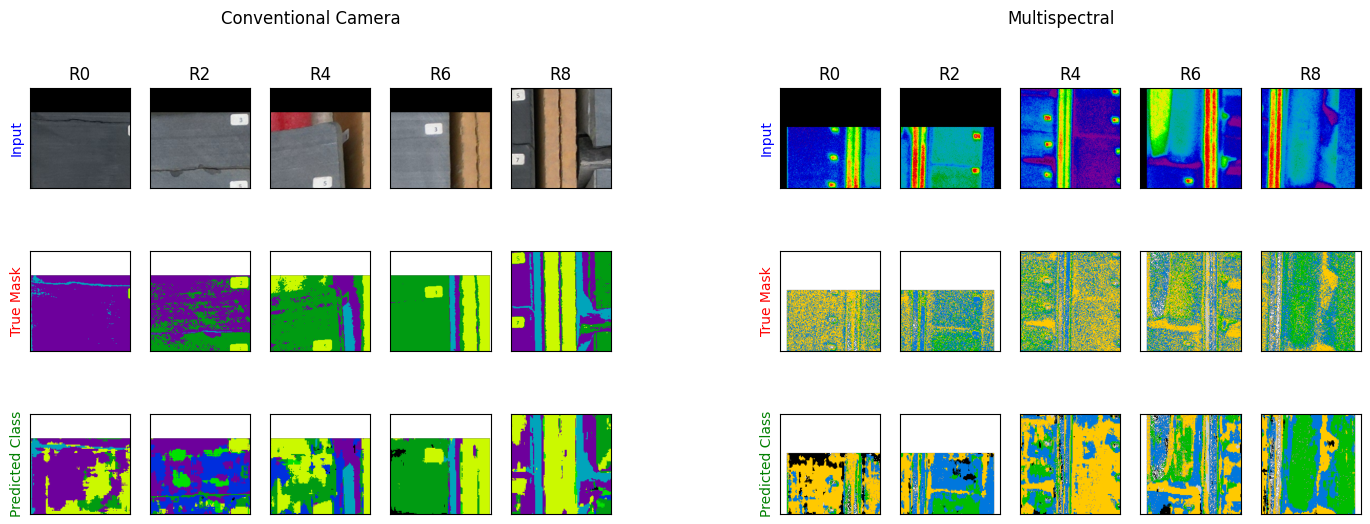

In [80]:
labels = ['Input', 'True Mask', 'Predicted Class']
mult = 2

fig = plt.figure(figsize=(15,6))
subfigs = fig.subfigures(1, 2)
axleft = subfigs[0].subplots(3, 5)
axright = subfigs[1].subplots(3, 5)

for j in range(5):
    k = j*mult
    axleft1, axleft2, axleft3 = axleft[:,j]
    axleft1.imshow(x_patched_cc[k])
    axleft1.set(title='R{}'.format(k))
    true = y_patched_cc[k].argmax(-1)
    pred = y_cc_pred[k].argmax(-1)
    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(true==0, pred)
    axleft2.imshow(dt, vmin=0, vmax=9, cmap='nipy_spectral')
    axleft3.imshow(dp, vmin=0, vmax=9, cmap='nipy_spectral')
    [a.set_ylabel(labels[i], color=['b','r','g'][i]) for i,a in enumerate([axleft1,axleft2,axleft3])] if j==0 else None
    
    axright1, axright2, axright3 = axright[:,j]
    axright1.imshow(x_patched_ms[k].mean(-1), cmap='nipy_spectral')
    axright1.set(title='R{}'.format(k))
    true = y_patched_ms[k].argmax(-1)
    pred = y_ms_pred[k].argmax(-1)
    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(true==0, pred)
    axright2.imshow(dt, vmin=0, vmax=4, cmap='nipy_spectral')
    axright3.imshow(dp, vmin=0, vmax=4, cmap='nipy_spectral')
    [a.set_ylabel(labels[i], color=['b','r','g'][i]) for i,a in enumerate([axright1,axright2,axright3])] if j==0 else None

    for i in range(3):
        [a.set(xticks=[], yticks=[]) for a in [axleft[i,j], axright[i,j]]]

subfigs[0].suptitle('Conventional Camera'); subfigs[1].suptitle('Multispectral')
plt.show()

***
# END